In [1]:
%load_ext dotenv
%dotenv

import os

%cd {os.getenv("PROJECT_PATH") or "."}

%load_ext autoreload
%autoreload 1

from IPython.display import display

/home/aris/projects/soc_molgen


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path
from absl import logging
from tqdm.notebook import tqdm, trange
from timeit import default_timer as timer
import pickle
from collections import defaultdict

logging.set_verbosity(logging.INFO)

sns.set_context("notebook")

In [3]:
from pandarallel import pandarallel

pandarallel.initialize(
    nb_workers=os.cpu_count(),
    progress_bar=True,
    verbose=2
)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
def show_df(df: pd.DataFrame):
    display(df.head())
    print(df.shape)

In [5]:
df_zinc250k = pd.read_csv("data/raw/zinc250k.csv", index_col=0)
df_zinc250k['source'] = "zinc250k"

show_df(df_zinc250k)

,smiles,logP,qed,SAS,source
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095,zinc250k
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004,zinc250k
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633,zinc250k
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753,zinc250k
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182,zinc250k


(249455, 5)


In [6]:
df_moses = pd.read_csv("data/raw/moses.csv").rename(columns={"SMILES": "smiles"})
df_moses['source'] = "moses"

show_df(df_moses)

,smiles,SPLIT,source
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,moses
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,moses
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test,moses
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,moses
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,moses


(1936962, 3)


In [7]:
df_chembl = pd.read_csv("data/raw/chembl_33_chemreps.txt", sep="\t", index_col=0).rename(columns={"canonical_smiles": "smiles"})
df_chembl['source'] = "chembl"

show_df(df_chembl)

,smiles,standard_inchi,standard_inchi_key,source
chembl_id,,,,
CHEMBL153534,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N,chembl
CHEMBL440060,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...,RSEQNZQKBMRQNM-VRGFNVLHSA-N,chembl
CHEMBL440245,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...,InChI=1S/C160H268N50O41/c1-23-27-41-95-134(228...,FTKBTEIKPOYCEX-OZSLQWTKSA-N,chembl
CHEMBL440249,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC...,InChI=1S/C124H154ClN21O39/c1-57(2)48-81-112(17...,UYSXXKGACMHPIM-KFGDMSGDSA-N,chembl
CHEMBL405398,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...,VDSXZXJEWIWBCG-UHFFFAOYSA-N,chembl


(2372674, 4)


In [8]:
# df_chembl.canonical_smiles.to_csv("data/processed/chembl.smi", index=False, header=False)

In [9]:
df_smiles = pd.concat([df_moses, df_chembl, df_zinc250k], axis=0, ignore_index=True)
df_smiles = df_smiles[['smiles', 'source']]
df_smiles = df_smiles.dropna().drop_duplicates().sort_values(by="smiles").reset_index(drop=True)

show_df(df_smiles)

,smiles,source
0,B.CC(=O)OC1CN2CCC1CC2,chembl
1,B.CP(c1ccccc1)c1ccc(O)cc1,chembl
2,B.Oc1ccc(P(c2ccccc2)c2ccccc2)cc1,chembl
3,BC#N.BC#N.CN(C)CCCCCCCCCCCCCCN(C)C,chembl
4,BC#N.BC#N.CN(C)CCCCCCCCCCCCN(C)C,chembl


(4558945, 2)


In [16]:
df_smiles_single = df_smiles[~df_smiles.smiles.str.contains("\.")]

show_df(df_smiles_single)

,smiles,source
28,BOP(=O)(O)COCCn1cnc2c(N)ncnc21,chembl
29,BOP(=O)(O)CO[C@H](C)Cn1cnc2c(N)ncnc21,chembl
30,BP(=O)(COCCn1cnc2c(N)ncnc21)OP(=O)(O)OP(=O)(O)O,chembl
31,BP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OP(=O)(O)OP...,chembl
32,BP(=O)(O)CC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=...,chembl


(4445834, 2)


In [19]:
import selfies as sf

def func(x:pd.Series):
    try:
        selfies = sf.encoder(x['smiles'])
        
        x['length'] = len(list(sf.split_selfies(selfies)))
    except Exception as e:
        return x
    return x

# _df = df_chembl[~df_chembl['canonical_smiles'].str.contains("\.")].parallel_apply(func, axis=1).dropna()
_df_len = df_smiles_single.parallel_apply(func, axis=1).dropna()

show_df(_df_len)

,length,smiles,source
28,29.0,BOP(=O)(O)COCCn1cnc2c(N)ncnc21,chembl
29,32.0,BOP(=O)(O)CO[C@H](C)Cn1cnc2c(N)ncnc21,chembl
30,45.0,BP(=O)(COCCn1cnc2c(N)ncnc21)OP(=O)(O)OP(=O)(O)O,chembl
31,48.0,BP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OP(=O)(O)OP...,chembl
32,34.0,BP(=O)(O)CC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=...,chembl


(4445800, 3)


In [20]:
_df_len.query('source == "moses"').length.describe()

count    1.936962e+06
mean     3.457629e+01
std      4.709183e+00
min      1.300000e+01
25%      3.100000e+01
50%      3.500000e+01
75%      3.800000e+01
max      5.500000e+01
Name: length, dtype: float64

In [21]:
_df_len.query('source == "zinc250k"').length.describe()

count    249455.000000
mean         37.433597
std           8.490383
min           8.000000
25%          32.000000
50%          37.000000
75%          43.000000
max          72.000000
Name: length, dtype: float64

<Axes: >

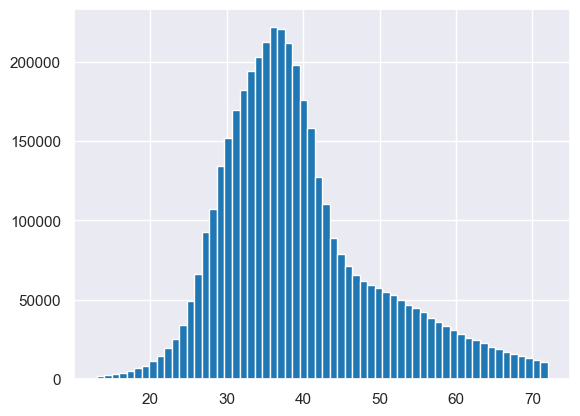

In [23]:
_df_len.query('13 <= length <= 72').length.hist(bins=72-13+1)

In [25]:
df_processed = _df_len.query('13 <= length <= 72').drop(columns=['length', 'source'])

show_df(df_processed)

,smiles
28,BOP(=O)(O)COCCn1cnc2c(N)ncnc21
29,BOP(=O)(O)CO[C@H](C)Cn1cnc2c(N)ncnc21
30,BP(=O)(COCCn1cnc2c(N)ncnc21)OP(=O)(O)OP(=O)(O)O
31,BP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OP(=O)(O)OP...
32,BP(=O)(O)CC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=...


(4253577, 1)


In [26]:
df_processed.to_csv("data/processed/zmc.smi", index=False, header=False)